In [37]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as pp
from pathlib import Path

# from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

In [41]:
import pickle
from collections import Counter

from nltk.stem import PorterStemmer
from models import nvdm
import torch

# Business Description Data
## SP500 Data

In [2]:
sp500_dir = Path('../SP500')
filenames = os.listdir(sp500_dir)
filenames[:5]

['FIS_Information Technology.txt',
 'MKC_Consumer Staples.txt',
 'COF_Financials.txt',
 'MTB_Financials.txt',
 'BRK.B_Financials.txt']

In [3]:
# Load data
ticker_sp50 = []
sector_sp50 = []
bds_sp50 = []
for fn in filenames:
    fn_first = fn.split('.txt')[0]
    ticker, sector = fn_first.split('_')

    path = os.path.join(sp500_dir, fn)
    with open(path, 'r', encoding="utf8") as f:
        f_text = f.read()
    
    ticker_sp50.append(ticker)
    sector_sp50.append(sector)
    bds_sp50.append(f_text)

In [4]:
# Basic sanity checks

# Just one file is named wrong
if ticker_sp50[19] == "VF Corporation":
    ticker_sp50[19] = "VFC"
assert all(s.isupper() for s in ticker_sp50)
assert all(s.title() == s for s in sector_sp50)
assert all (len(bd) > 0 for bd in bds_sp50)

## Larger Dataset - excluding SP500

In [5]:
# NOTE: we use the cleaned version of bds_1.txt.
# Format is the same except the business descriptions are preprocessed.

f = open("./data/bds_1_clean.txt", "r", encoding="utf8")
f_lines = f.readlines()
f.close()

company_ids_all = f_lines[0::2]
company_descriptions_all = f_lines[1::2]
company_tickers = [x.split(':')[0] for x in company_ids_all]
removeSP = np.in1d(np.array(company_tickers), list(ticker_sp50))

bds_all = []
ticker_all = []
for i, d in enumerate(company_descriptions_all):
    if (len(d) > 3000) and not removeSP[i]:
        bds_all.append(d)
        ticker_all.append(company_ids_all[i])

# Get Returns Data

In [6]:
start_d = np.datetime64('2018-01-01')
end_d = np.datetime64('2020-01-01')
business_ds = pd.date_range(start_d, end_d, freq='B')

price_data = pd.read_csv('./data/Price.csv')

select_these = np.in1d(price_data.tic.values, list(ticker_sp50))
price_sp50 = price_data.loc[select_these, ['tic', 'datadate', 'prccd']]
price_sp50['datadate'] = pd.to_datetime(price_sp50['datadate'], format='%Y%m%d')
price_sp50 = pd.pivot_table(price_sp50,index='datadate',columns='tic',values='prccd')
price_sp50 = price_sp50.ffill(limit=5)
price_sp50 = price_sp50.reindex(business_ds)
price_sp50 = price_sp50.dropna(axis=0)

returns_sp50 = np.log(price_sp50) - np.log(price_sp50.shift(1))
returns_sp50 = returns_sp50.dropna(axis=0)

/home/aaron/Documents/ML_UCL_MSc/NLP_COMP0087/venv-comp0087/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (1,4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Explaining Returns with NVDM
## Get the pretrained NVDM torch models

In [7]:
# Load vocabulary object.
with open("./vocabs/vocab_bds_1_clean_10000.pickle", "rb") as f:
    vocab = pickle.load(f)

In [8]:
# Load pretrained NVDM models for different k.

MODELSAVE_PATH = "./modelsaves"

models_k = dict()
k_values = []

hidden_size = 500

for filename in os.listdir(MODELSAVE_PATH):
    
    num_topics = filename.split("_")[1][1:]
    num_topics = int(num_topics)
    k_values.append(num_topics)
    
    model = nvdm.NVDM(len(vocab), hidden_size, num_topics, 1, "cpu")
    model.load_state_dict(torch.load(os.path.join(MODELSAVE_PATH, filename), map_location="cpu"))
    model.eval()
    models_k[num_topics] = model
    
    # Hidden size was hard-coded in NVDM_Experiments, sanity check
    assert model.n_hidden == hidden_size

In [9]:
models_k[10]

NVDM(
  (embed_bow): EmbeddingBag(10001, 10001, mode=sum)
  (encoder): Sequential(
    (0): Linear(in_features=10001, out_features=500, bias=True)
    (1): Tanh()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): Tanh()
  )
  (mu): Linear(in_features=500, out_features=10, bias=True)
  (log_sigma): Linear(in_features=500, out_features=10, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=10001, bias=True)
  )
)

## Get Features for S&P 500
More manual work needed for NVDM (no fit/transform() functions)

In [34]:
def nvdm_transform(model, bow):
    # replacing this_lda.transform(tf_sp50)
    vocab_topic_mat = model.decoder[0].weight.data.detach().clone().numpy()
    doc_topic_mat = bow @ vocab_topic_mat
    return doc_topic_mat

In [17]:
# Make the BOW matrix manually, using the existing Vocab's token-to-index mapping.
bow_sp50 = np.zeros((len(bds_sp50), len(vocab)))

for d, bd in enumerate(bds_sp50):
    token_idxs = vocab.lookup_indices(bd.split(" "))
    word_counts = Counter(token_idxs)
    for w, count in word_counts.items():
        bow_sp50[d, w] = count   
bow_sp50.shape

(503, 10001)

In [20]:
# Get the learned semantic embeddings from a model (e.g. K=10)
vocab_topic_mat = models_k[10].decoder[0].weight.data.detach().clone().numpy()
vocab_topic_mat.shape

(10001, 10)

In [30]:
# This should represent each document as a linear combination of its word embeddings.
# i.e. for each document, sum its word embeddings.
doc_topic_mat = bow_sp50 @ vocab_topic_mat
doc_topic_mat.shape

(503, 10)

In [31]:
# Continue the same way as LDA...
features_sp50 = doc_topic_mat
features_sp50_df = pd.DataFrame(index=ticker_sp50, data=features_sp50)

## Loop Over Dates and Perform OLS Regression

In [32]:
all_dates = returns_sp50.index
max_f = 19
adj_r2_features = []

for dd in all_dates:
    reg_data = returns_sp50.loc[[dd]].transpose().join(features_sp50_df.loc[:, 0:max_f]).dropna(axis=0).values
    y = reg_data[:, 0]
    X = reg_data[:, 1:]

    std_scaler = StandardScaler()
    X = std_scaler.fit_transform(X)

    X = sm.add_constant(X, prepend=False)
    ols_model = sm.OLS(y, X)
    res = ols_model.fit()
    adj_r2_features.append(res.rsquared_adj)

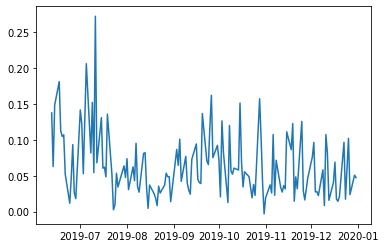

In [33]:
pp.plot(all_dates, adj_r2_features)

## Comparing Different K

Next, calculate average regression adjusted $R^2$ for different K

In [49]:
tf_sp50 = bow_sp50
all_ks = list(sorted(models_k.keys()))

all_adj_r2 = []
for k in all_ks:
    print(f'Running for k = {k}')
    
    features_sp50 = nvdm_transform(models_k[k], bow_sp50)
    features_sp50_df = pd.DataFrame(index=ticker_sp50, data=features_sp50)
    adj_r2_dates = []
    for dd in all_dates:
        reg_data = returns_sp50.loc[[dd]].transpose().join(features_sp50_df.loc[:, 0:max_f]).dropna(axis=0).values
        y = reg_data[:, 0]
        X = reg_data[:, 1:]

        std_scaler = StandardScaler()
        X = std_scaler.fit_transform(X)

        X = sm.add_constant(X, prepend=False)
        ols_model = sm.OLS(y, X)
        res = ols_model.fit()
        adj_r2_dates.append(res.rsquared_adj)
    
    all_adj_r2.append(np.mean(adj_r2_dates))

Running for k = 5
Running for k = 10
Running for k = 15
Running for k = 20
Running for k = 25
Running for k = 30
Running for k = 35
Running for k = 40
Running for k = 50


In [50]:
all_adj_r2

[0.030530778103586124,
 0.06320451238728353,
 0.07822433347157239,
 0.091585397296027,
 0.08465441657147543,
 0.0943596933661213,
 0.08346258939772003,
 0.0818278308987715,
 0.08128913123714297]